# Feed-Forward Neural Netowrk
A simple implementation for a classification problem of predicting avocado ripeness

## Problem description

**Goal**: Predict avocado ripeness

## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

set_config(transform_output='pandas')

## Exploratory Analysis

In [2]:
raw = pd.read_csv("data/avocado_ripeness_dataset.csv")
raw

,firmness,hue,saturation,brightness,color_category,sound_db,weight_g,size_cm3,ripeness
0,14.5,19,40,26,black,34,175,261,ripe
1,71.7,53,69,75,green,69,206,185,pre-conditioned
2,88.5,60,94,46,dark green,79,220,143,hard
3,93.8,105,87,41,dark green,75,299,140,hard
4,42.5,303,58,32,purple,63,200,227,breaking
...,...,...,...,...,...,...,...,...,...
245,94.1,83,80,58,dark green,72,254,134,hard
246,21.6,17,36,19,black,47,182,240,firm-ripe
247,14.0,4,40,17,black,37,188,274,ripe
248,61.5,63,87,75,green,65,261,162,pre-conditioned


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   firmness        250 non-null    float64
 1   hue             250 non-null    int64  
 2   saturation      250 non-null    int64  
 3   brightness      250 non-null    int64  
 4   color_category  250 non-null    object 
 5   sound_db        250 non-null    int64  
 6   weight_g        250 non-null    int64  
 7   size_cm3        250 non-null    int64  
 8   ripeness        250 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 17.7+ KB


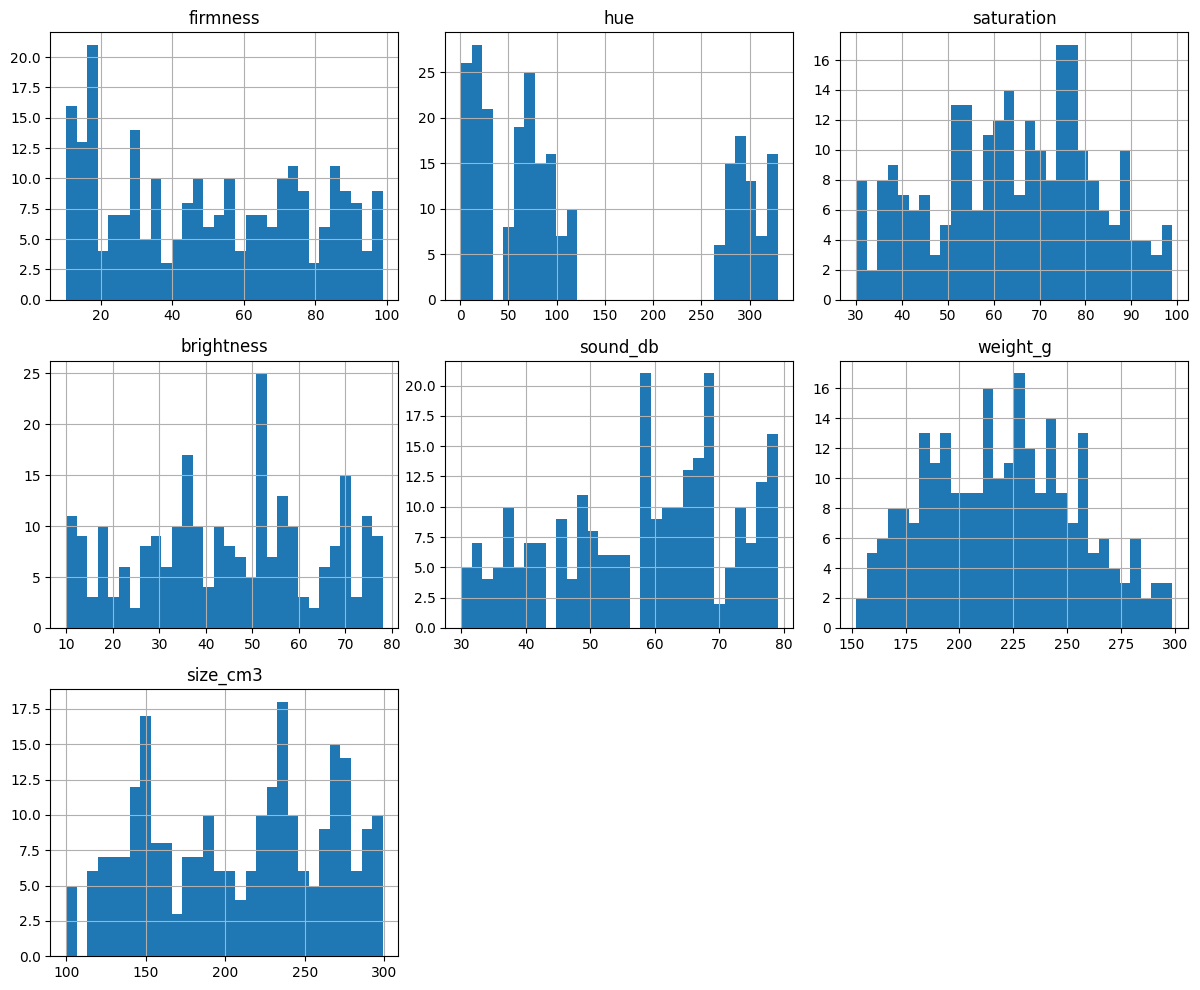

In [ ]:
# this diagrams show if the data is gaussian (bell shape) or not
# this is useful to determine the best scaler: StandardScaler, MinMaxScaler or RobustScaler.
# by default, StandardScaler should be quite good, but is best with gaussian data
# if the data is not Gaussian, MinMax can be better and RobustScaler should be used in case of big outliers

raw.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

## Pre-Processing